# importing the libraries

In [29]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import yfinance as yf

# get the stock data by yfinance library 

In [10]:
stock_data = yf.download("AAPL", start = "2017-01-01", end = "2022-01-01")
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.095850,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.065523,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.203165,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.506430,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.758369,134247600


# show the previous data 

Text(0, 0.5, 'prices ($)')

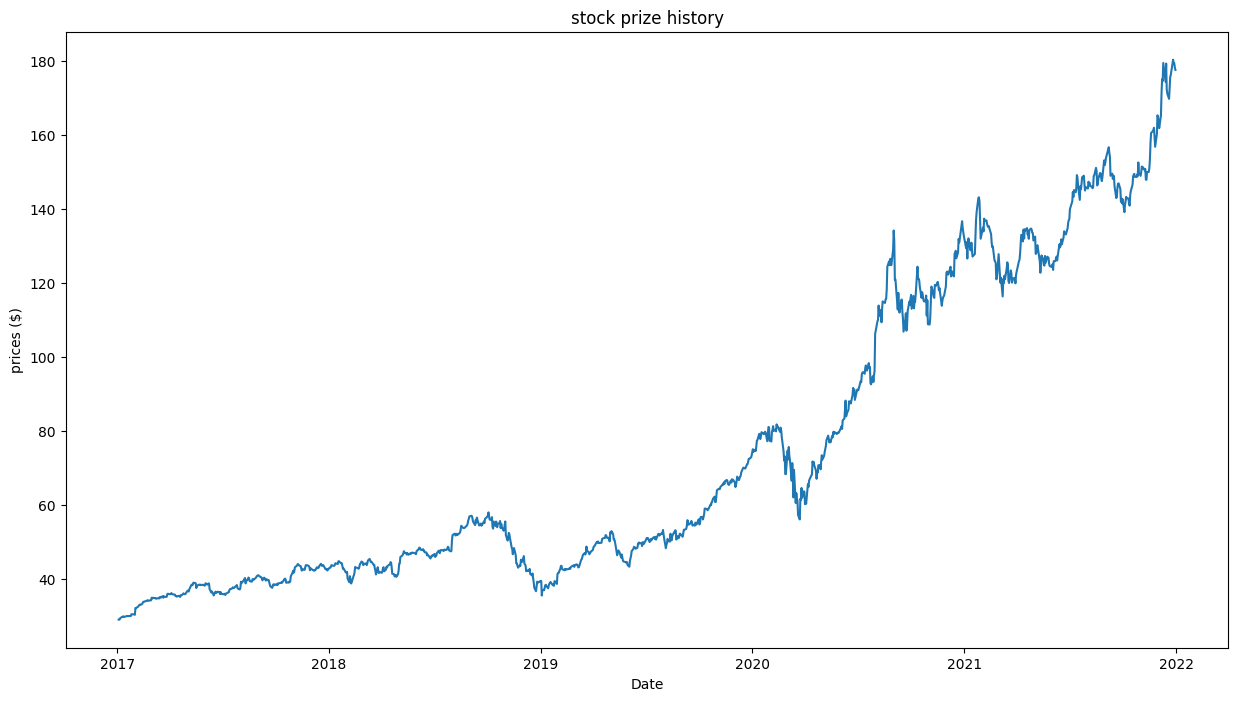

In [12]:
plt.figure(figsize=(15,8))
plt.title("stock prize history")
plt.plot(stock_data['Close'])
plt.xlabel("Date")
plt.ylabel("prices ($)")

# preparation of training set
## Here we take only 80% closing prices and we take closing prices because we only need it for LSTM model

In [16]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values) * 0.8)

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

# Preparation of test set
## And convert the feature data and label data into Numpy array.

In [18]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Here we setup the LSTM Architecture 
## By using the Tensorflow

In [21]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences = False))
model.add(layers.Dense(25))
mode.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
Total params: 123,725
Trainable params: 123,725
Non-trainable params: 0
_________________________________________________________________


# Training LSTM model 
## Train the model by fitting it with the training set.

In [22]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, batch_size = 1, epochs = 3)

Epoch 1/3
948/948 [==============================] - 23s 22ms/step - loss: 0.0025
Epoch 2/3
948/948 [==============================] - 21s 22ms/step - loss: 6.9187e-04
Epoch 3/3
948/948 [==============================] - 21s 22ms/step - loss: 5.6068e-04


# Model Evaluation
## Use the inversr_transform method to denormalize the predicted stock prices.
## we apply the root mean square formula to calculate the degree of discrepancy between the predicted prices and real prices and display the result .

In [25]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test.reshape(-1, 1))**2)
rmse

8/8 [==============================] - 0s 25ms/step


8.666275430504545

# Visualizing the predicted prices
## We use the python Matplolib for plot our predicted prices

C:\Users\Hemant\AppData\Local\Temp\ipykernel_7884\3403546080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['predictions'] = predictions[:, 0]


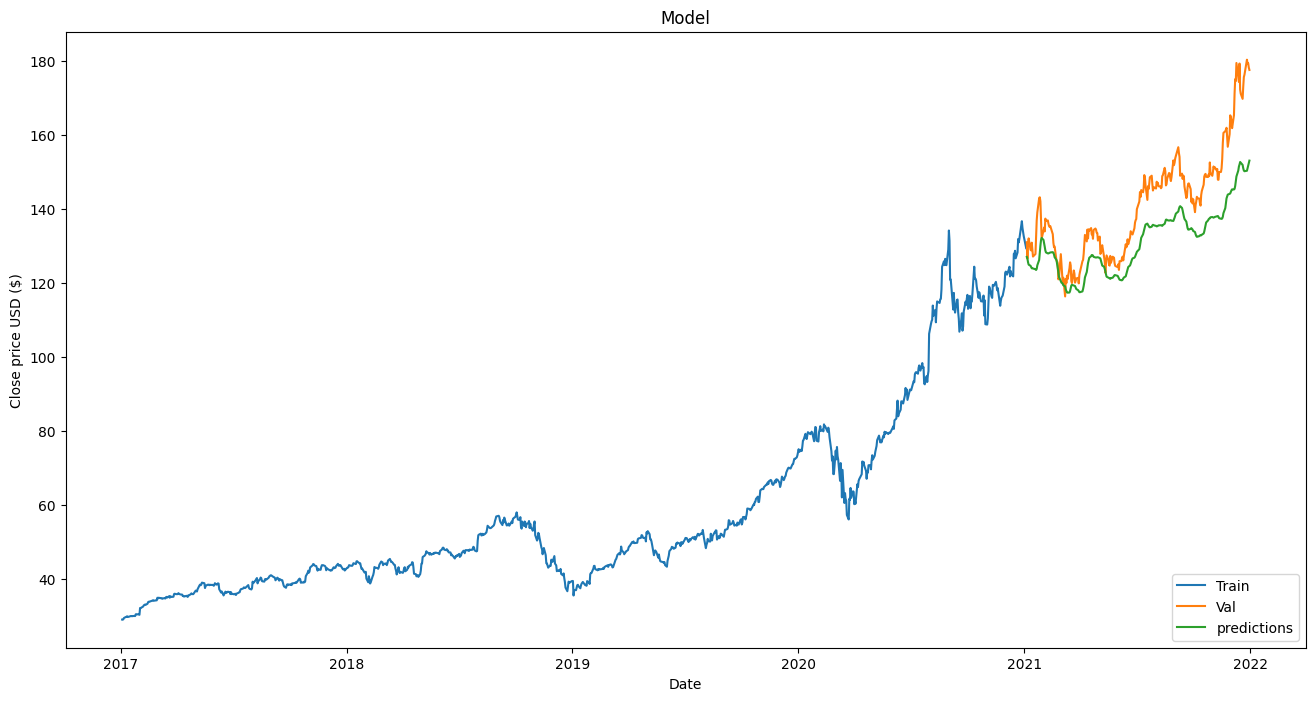

In [28]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['predictions'] = predictions[:, 0]

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'predictions']])
plt.legend(['Train', 'Val', 'predictions'], loc = 'lower right')
plt.show()